In [32]:
import pandas as pd
import cdt
import pickle
import networkx as nx
import matplotlib.pyplot as plt

In [43]:
# read data
df = pd.read_csv('../../data/session-df-ak.csv')
#df = pd.read_csv('../../data/training_set/log_mini.csv')
#df = pickle.load( open( "../../data/df_causal_discovery.p", "rb") )

In [44]:
df.columns

Index(['Unnamed: 0', 'session_id', 'session_position', 'session_length',
       'track_id_clean', 'skip_1', 'skip_2', 'skip_3', 'not_skipped',
       'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'skip', 'custom_skip', 'pause_before_play', 'custom_pause_before_play'],
      dtype='object')

In [45]:
cols1 = ['custom_skip', 'hour_of_day', 'session_position', 'premium', 'session_length'] # , 'custom_pause_before_play'
df1 = df[cols1]
for col in cols1:
    df1[col] = df1[col].astype(int)

#df1 = df1[df1['hour_of_day'] > 10][df1['hour_of_day'] < 15]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
def bucket_sess_pos(x):
    if x <= 5:
        return 0
    elif x >= 6 and x <= 10:
        return 1
    elif x >= 11 and x <= 15:
        return 2
    return 3

df1['bucket_session_position'] = df1.apply(lambda x: bucket_sess_pos(x.session_position), axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
def bucket_sess_len(x):
    if x <= 13:
        return 0
    elif x >= 14 and x <= 17:
        return 1
    return 2

df1['bucket_session_length'] = df1.apply(lambda x: bucket_sess_len(x.session_length), axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
def bucket_sess_len(x):
    if x <= 5:
        return 0
    elif x >= 6 and x <= 10:
        return 1
    elif x >= 11 and x <= 15:
        return 2
    elif x >= 16 and x <= 20:
        return 3
    return 4

df1['bucket_hours'] = df1.apply(lambda x: bucket_sess_len(x.hour_of_day), axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
df1['bucket_session_length'].value_counts()

2    112740
0     31325
1     23815
Name: bucket_session_length, dtype: int64

In [49]:
df1['bucket_session_position'].value_counts()

0    50000
1    50000
2    39406
3    28474
Name: bucket_session_position, dtype: int64

In [51]:
df1['bucket_hours'].value_counts()

2    51736
3    51705
4    25970
1    20534
0    17935
Name: bucket_hours, dtype: int64

In [53]:
cols1 = ['custom_skip', 'bucket_hours', 'bucket_session_position', 'premium', 'bucket_session_length'] # , 'custom_pause_before_play'
for col in cols1:
    df1[col] = df1[col].astype(int)

df1 = df1[cols1]
#df1 = df1[df1['hour_of_day'] > 10][df1['hour_of_day'] < 15]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


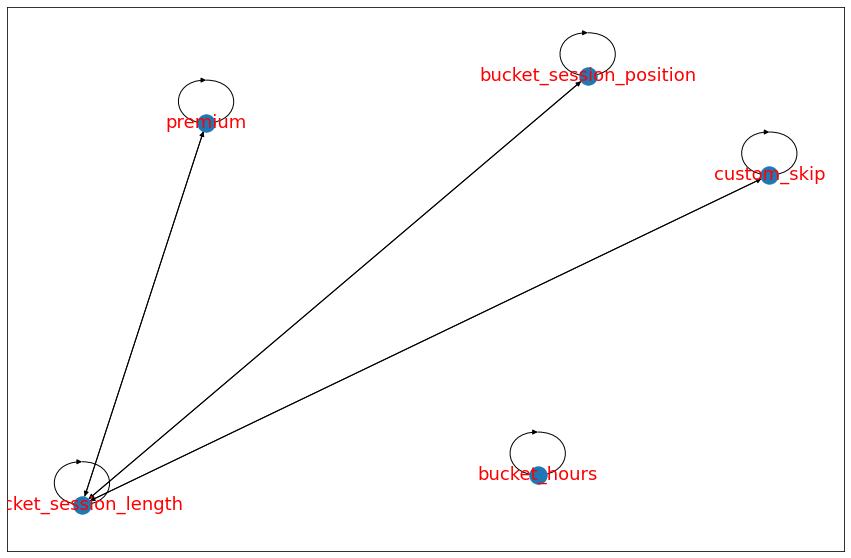

In [54]:
# Get skeleton graph
# initialize graph lasso
glasso = cdt.independence.graph.Glasso()

# apply graph lasso to data
skeleton = glasso.predict(df1)# visualize network
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

In [60]:
skeleton = glasso.predict(df1)# visualize network
for i in df1.columns:
    try:
        skeleton.remove_edge("custom_skip",i)
        skeleton.remove_edge(i,i)
    except Exception:
        print(i)
        pass

custom_skip
bucket_hours
bucket_session_position
premium


In [62]:
skeleton.remove_edge('premium','premium')
skeleton.remove_edge('bucket_hours','bucket_hours')
skeleton.remove_edge('bucket_session_position','bucket_session_position')
# skeleton.remove_edge('premium','hour_of_day')
# skeleton.remove_edge('hour_of_day','premium')
# skeleton.add_edge('premium', 'custom_skip')

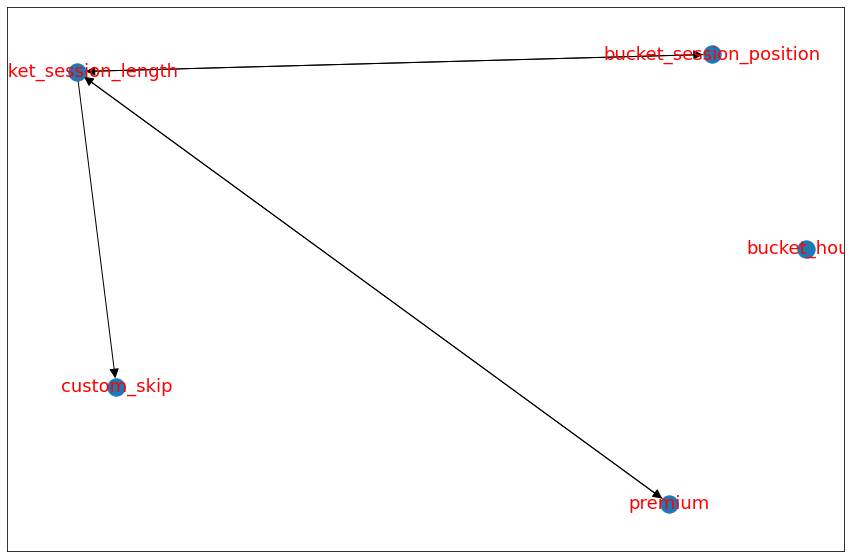

In [63]:
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r', arrowsize=20)

PC is ran on the skeleton of the given graph.


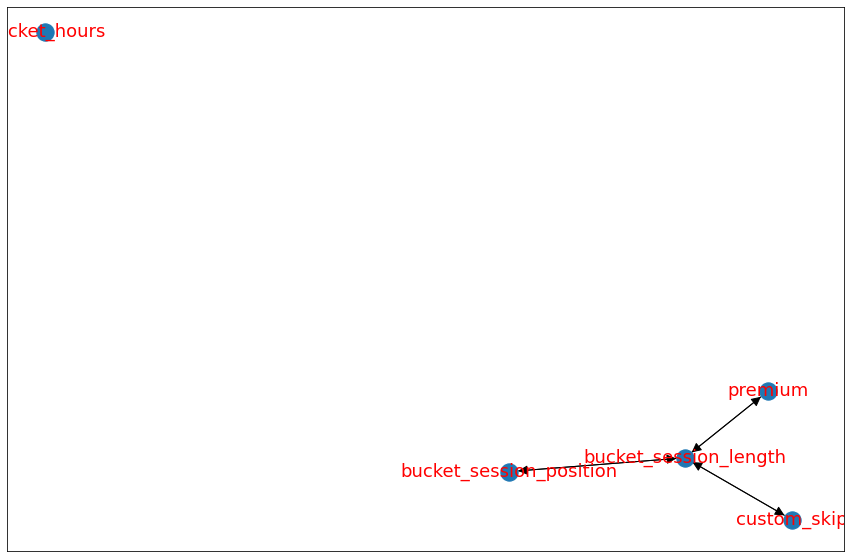

In [64]:
model_pc = cdt.causality.graph.PC()
model_pc.arguments['{SKELETON}'] = 'TRUE'
#graph_pc = model_pc.predict(df1, skeleton)
graph_pc = model_pc.predict(df1, skeleton)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc, font_size=18, font_color='r', arrowsize=20)

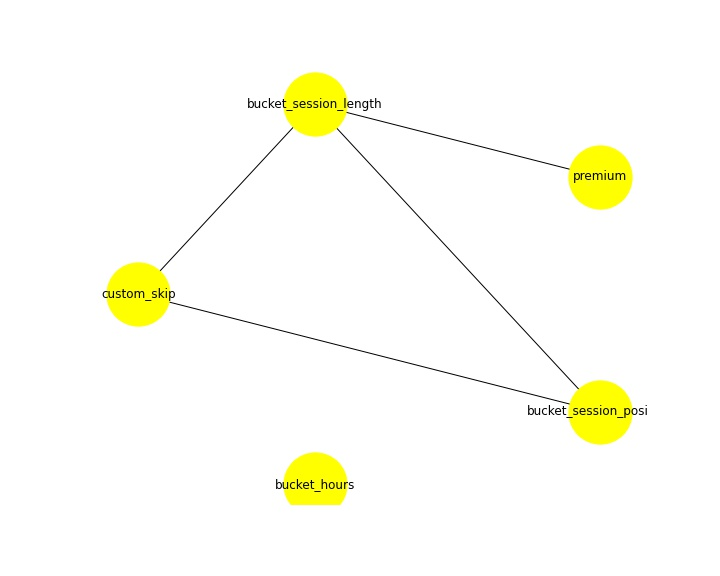

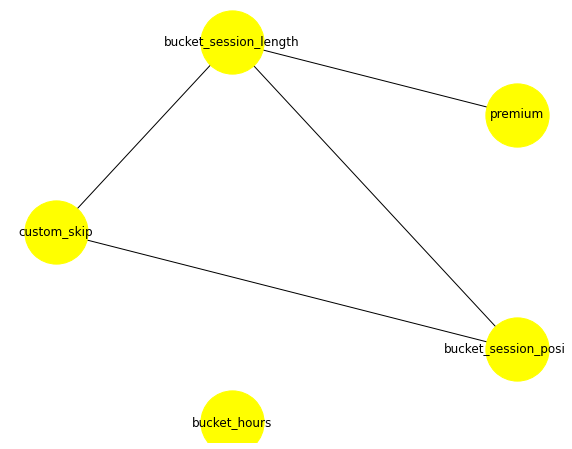

In [81]:
plt.figure(figsize=(10,8))
solid_edges = [(n1, n2) for n1, n2, e in graph_pc.edges(data=True) if "style" not in e]
dashed_edges = [
    (n1, n2) for n1, n2, e in graph_pc.edges(data=True) if ("style" in e and e["style"] == "dashed")
]
plt.clf()

pos = nx.layout.shell_layout(graph_pc)
nx.draw_networkx_nodes(graph_pc, pos, node_color="yellow", node_size=4000)
nx.draw_networkx_edges(graph_pc, pos, edgelist=solid_edges, arrowstyle="-|>", arrowsize=12)
nx.draw_networkx_edges(
    graph_pc, pos, edgelist=dashed_edges, arrowstyle="-|>", style="dashed", arrowsize=12
)

labels = nx.draw_networkx_labels(graph_pc, pos)

plt.axis("off")
plt.savefig('../../img/gg.jpg')

from IPython.display import Image, display
display(Image(filename="../../img/gg.jpg"))

PC is ran on the skeleton of the given graph.


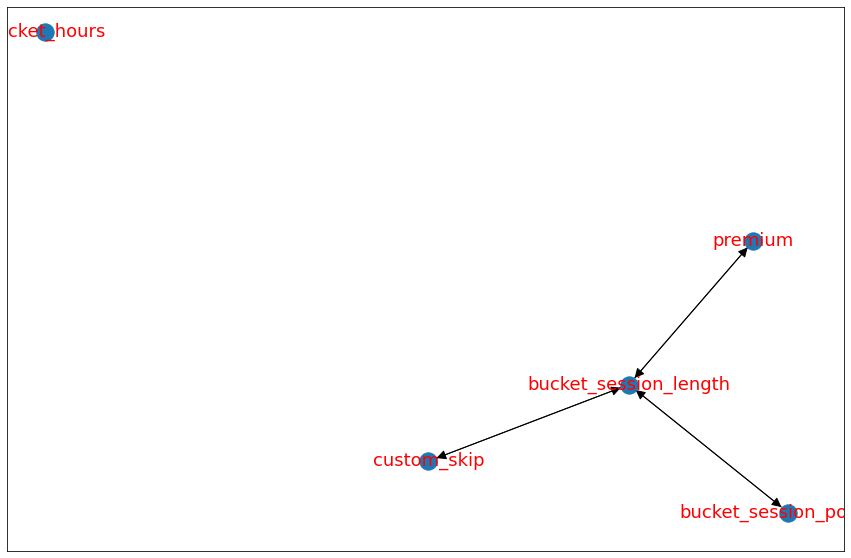

In [65]:
# Use causal discovery to get causal models# PC algorithm
model_pc = cdt.causality.graph.PC()
model_pc.arguments['{SKELETON}'] = 'TRUE'
#graph_pc = model_pc.predict(df1, skeleton)
graph_pc = model_pc.orient_directed_graph(df1, skeleton)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc, font_size=18, font_color='r', arrowsize=20)

In [29]:
# GS algorithm
model_ges = cdt.causality.graph.GS(score='int')
model_ges.arguments['{SKELETON}'] = 'TRUE'
# graph_ges = model_ges.predict(df1, skeleton)
graph_ges = model_ges.predict(df1, skeleton)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_ges, font_size=18, font_color='r', arrowsize=20)

The algorithm is ran on the skeleton of the given graph.



R Python Error Output 
-----------------------

[Errno 2] No such file or directory: '/var/folders/md/5m2hbvy91mb1b69cyygvfmw40000gn/T/cdt_bnlearn_0c49c275-26d8-4139-9cba-fa7857cf125f/result.csv'


RuntimeError: RProcessError 
R Process Error Output 
-----------------------
Error in data.type(x) : 
  variable X0 is not supported in bnlearn (type: integer).
Calls: gs -> bnlearn -> check.data -> data.type
Execution halted


GES is ran on the skeleton of the given graph.


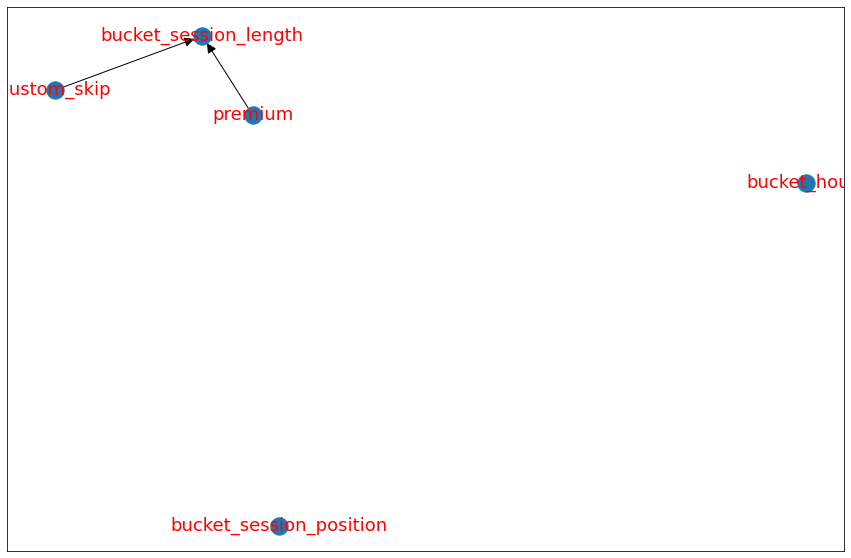

In [67]:
# GES algorithm
model_ges = cdt.causality.graph.GES(score='int')
model_ges.arguments['{SKELETON}'] = 'TRUE'
# graph_ges = model_ges.predict(df1, skeleton)
graph_ges = model_ges.orient_directed_graph(df1, skeleton)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_ges, font_size=18, font_color='r', arrowsize=20)

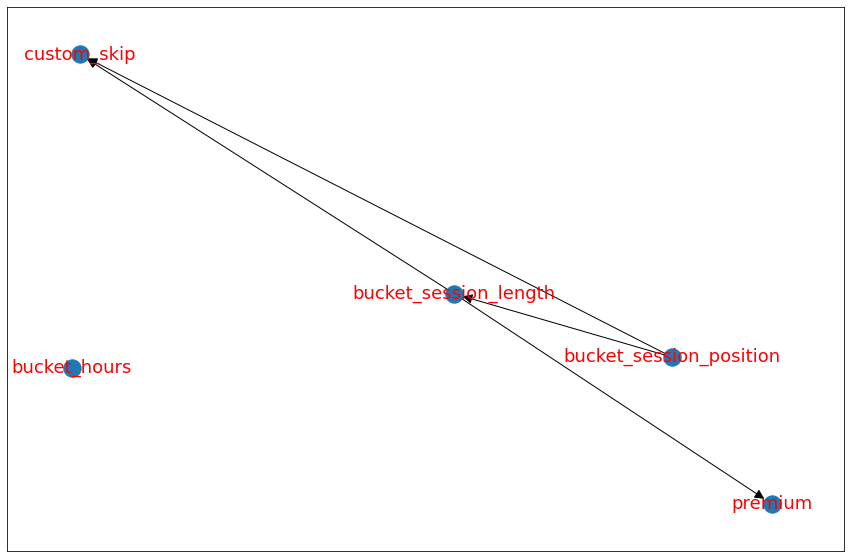

In [66]:
# Use causal discovery to get causal models# PC algorithm
model_lingam = cdt.causality.graph.LiNGAM()
graph_pc = model_lingam.predict(df1)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc, font_size=18, font_color='r', arrowsize=20)